In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# fpath = "F:\\pp1_data_processing\\2023-05-22_21-17-37 dac showing pacman.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-22_22-36-06 dac showing pacman 200MHz.csv"
fpath = "C:\\Users\\ionca\\Desktop\\pp1\\2023-05-23_17-58-21 dac 200MHz one line.csv"
df = pd.read_csv(fpath)

In [9]:
# get all the falling edges of !vid_conv where the dac data is latched
conv_diffs = df[' !VID_CONV'].diff()
dacdf = df.loc[conv_diffs == -1].copy()
dacdf.reset_index(inplace=True, drop=True)
dacdf.drop(columns=' !VID_CONV', inplace=True)
dacdf

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK
0,0.031196,0,1,1,0,1,1,0,0,0
1,0.031196,1,0,0,0,1,1,0,0,0
2,0.031196,1,0,0,1,1,1,0,0,0
3,0.031196,1,1,0,1,1,1,0,0,0
4,0.031196,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1228,0.031281,0,1,1,0,1,1,0,0,0
1229,0.031281,0,0,0,0,1,1,0,0,0
1230,0.031281,1,0,0,1,1,1,0,0,0
1231,0.031281,1,1,1,0,1,1,0,0,0


In [10]:
# convert binary columns to numpy
bits_arr = dacdf[[' DAC0', ' DAC1', ' DAC2', ' DAC3', ' DAC4', ' DAC5', ' DAC6', ' DAC7']].to_numpy()
# convert to decimal
decimal_arr = np.sum(bits_arr * (2**np.arange(0,8)), axis=1)
# store in new column
dacdf['VALUE'] = decimal_arr

# obtained from output of MC10322's attached video amp. R66 relative to GND.
voltage_when_0 = 2.125 # V, aka Normal Black
voltage_when_255 = 4.185 # V, aka Normal White
voltage_when_blk = 1.86 # V, aka Blanking

# remap values to voltages
dacdf['VOLTAGE'] = (decimal_arr / 255) * (voltage_when_255 - voltage_when_0) + voltage_when_0 
dacdf.loc[dacdf[' VID_BLK'] == 1, 'VOLTAGE'] = voltage_when_blk
dacdf.head()

,Time[s],DAC0,DAC1,DAC2,DAC3,DAC4,DAC5,DAC6,DAC7,VID_BLK,VALUE,VOLTAGE
0,0.031196,0,1,1,0,1,1,0,0,0,54,2.561235
1,0.031196,1,0,0,0,1,1,0,0,0,49,2.520843
2,0.031196,1,0,0,1,1,1,0,0,0,57,2.585471
3,0.031196,1,1,0,1,1,1,0,0,0,59,2.601627
4,0.031196,0,1,1,0,1,1,0,0,0,54,2.561235


array([<Axes: xlabel='Time[s]'>], dtype=object)

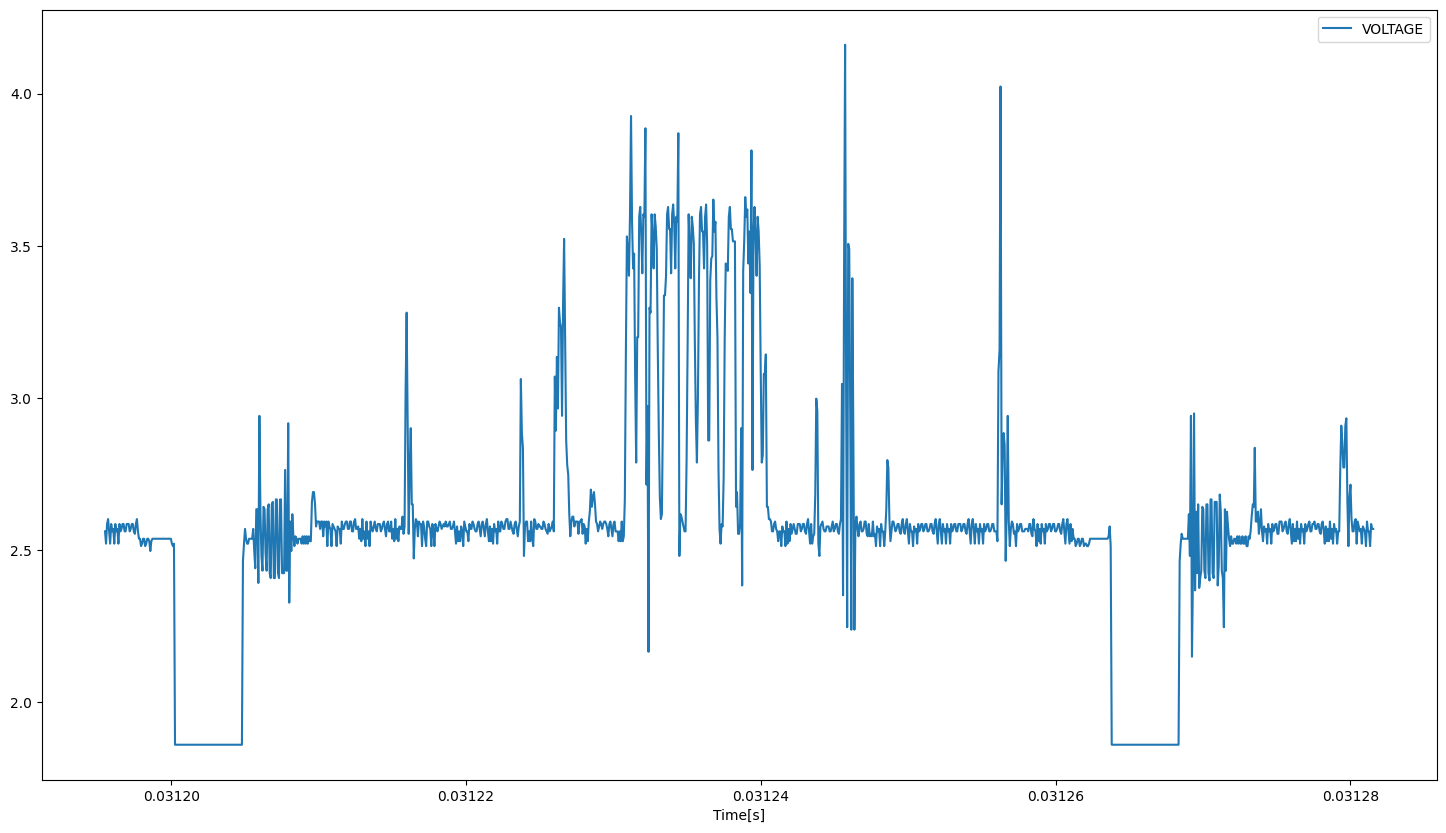

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
dacdf.plot(x='Time[s]', y=['VOLTAGE'], subplots=True, ax=ax)

In [46]:
df['timedt'] = pd.to_datetime(df['Time[s]'], unit='s')
df['timediff'] = df['timedt'].diff().dt.total_seconds()
vidconv_rising = (df[' !VID_CONV'].diff()) == 1
vidconv_rising

0       False
1        True
2       False
3       False
4        True
        ...  
2939    False
2940     True
2941    False
2942     True
2943    False
Name:  !VID_CONV, Length: 2944, dtype: bool

In [ ]:

conv_signal = df[' !VID_CONV'].to_numpy()
fig, ax = plt.subplots()
ax.plot(np.abs(conv_freq))
ax.set_yscale('log')


In [ ]:
# get indices of rising edges of blanking pulse ' VID_BLK'
blk_diffs = dacdf[' VID_BLK'].diff()


C:\Users\ionca\AppData\Local\Temp\ipykernel_14316\2136672942.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dacdf.plot(x='Time[s]', y=['VALUE', ' VID_BLK', 'VOLTAGE'], subplots=True, ax=ax)


array([<Axes: xlabel='Time[s]'>, <Axes: xlabel='Time[s]'>,
       <Axes: xlabel='Time[s]'>], dtype=object)

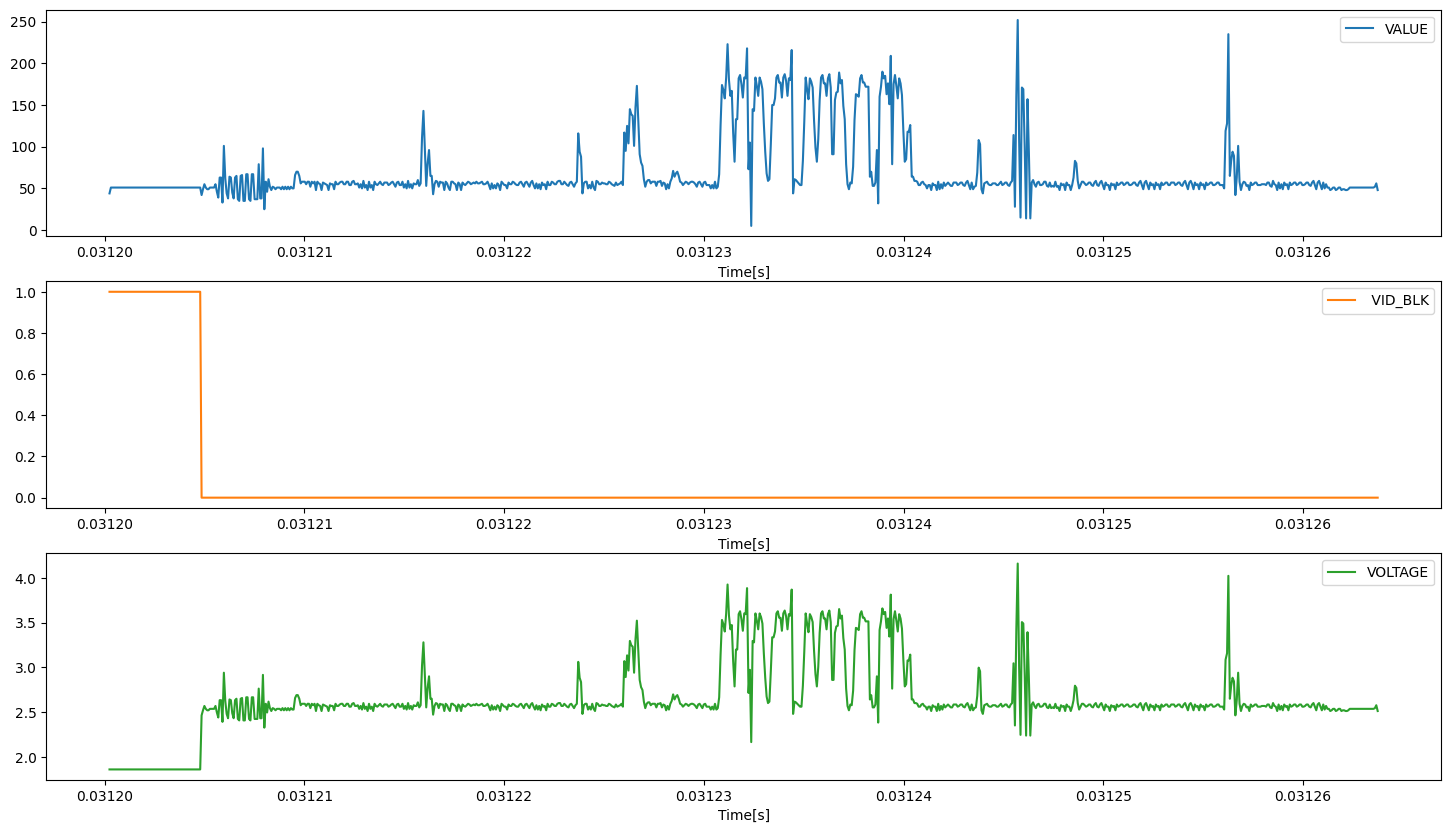

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
dacdf.plot(x='Time[s]', y=['VALUE', ' VID_BLK', 'VOLTAGE'], subplots=True, ax=ax)